In [1]:
# 下載資料集
# !kg download -c jigsaw-toxic-comment-classification-challenge
# !unzip train.csv.zip 
# !unzip test.csv.zip 
# !unzip sample_submission.csv.zip 

In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 50000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

/home/dllab/anaconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/dllab/anaconda3/envs/DL3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [5]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [6]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

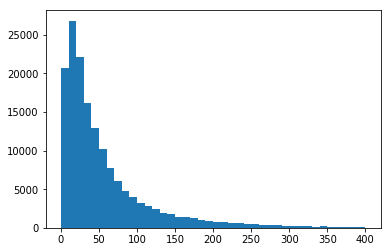

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [76]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,CuDNNLSTM,CuDNNGRU,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D,BatchNormalization
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [77]:
embed_size = 1024
x = Embedding(max_features, embed_size)(inp)

In [78]:
x = Bidirectional(CuDNNLSTM(120  , return_sequences=True,name='lstm_layer'))(x)

In [79]:
x = Dense(60 , activation="elu")(x)

In [80]:
x = Bidirectional(CuDNNGRU(60  , return_sequences=True,name='lstm_layer'))(x)

In [81]:
x = GlobalMaxPool1D()(x)

In [82]:
x = Dropout(0.1)(x)

In [83]:
# x = BatchNormalization()(x) 

In [84]:
x = Dense(240 , activation="elu")(x)

In [85]:
x = Dropout(0.1)(x)

In [86]:
# x = Dense(240 , activation="elu")(x)

In [87]:
x = BatchNormalization()(x) 

In [88]:
x = Dense(60 , activation="elu")(x)

In [89]:
x = Dropout(0.1)(x)

In [90]:
x = BatchNormalization()(x) 

In [91]:
x = Dense(6, activation="sigmoid")(x)

In [92]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [93]:

batch_size = 32
epochs = 2
# model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1,shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 638s 4ms/step - loss: 0.0802 - acc: 0.9714 - val_loss: 0.0560 - val_acc: 0.9799
Epoch 2/2
143613/143613 [==============================] - 636s 4ms/step - loss: 0.0451 - acc: 0.9833 - val_loss: 0.0476 - val_acc: 0.9822


In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 1024)         51200000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200, 240)          1100160   
_________________________________________________________________
dense_13 (Dense)             (None, 200, 60)           14460     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 120)          43920     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 120)               0         
__________

In [95]:
classes = model.predict(X_te, batch_size=256)

In [96]:
print(classes)

[[9.84587908e-01 1.93819880e-01 8.44859362e-01 9.83614251e-02
  8.82458091e-01 2.80203313e-01]
 [3.86767648e-03 5.52292986e-05 4.84663527e-04 1.19539516e-04
  6.47081470e-04 2.15047199e-04]
 [1.95417069e-02 1.78275222e-04 2.10775738e-03 3.91555892e-04
  2.60336837e-03 5.88771480e-04]
 ...
 [3.58493906e-03 1.38608521e-04 1.09755842e-03 6.67086351e-05
  3.32206546e-04 2.68342352e-04]
 [1.85083263e-04 1.58764433e-05 5.66037379e-05 7.94961397e-06
  1.55539965e-05 3.09336101e-05]
 [9.56885338e-01 5.88972345e-02 7.51349628e-01 2.05774233e-02
  6.31780088e-01 6.73645586e-02]]


In [97]:
# submission = pd.DataFrame({
#     "id": test["id"],
#     list_classes: classes})
# list_classes.insert(0,"id")
# list_classes.remove("id")
# print(list_classes)
# classes[:,:-1] = test["id"]
# print(classes[:,:0] )
# a = np.append(test["id"],classes,axis=1)
# classes[:,:0] = (np.array(test["id"]))
# print(a)
submission = pd.DataFrame(
      classes, columns=list_classes)


submission["id"] = test["id"]

submission = submission[["id","toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
print(submission)
submission.to_csv('titanic_lin.csv', index=False)

                      id     toxic  severe_toxic   obscene    threat  \
0       00001cee341fdb12  0.984588      0.193820  0.844859  0.098361   
1       0000247867823ef7  0.003868      0.000055  0.000485  0.000120   
2       00013b17ad220c46  0.019542      0.000178  0.002108  0.000392   
3       00017563c3f7919a  0.007751      0.000214  0.001441  0.000238   
4       00017695ad8997eb  0.002461      0.000041  0.000380  0.000081   
5       0001ea8717f6de06  0.005126      0.000059  0.000588  0.000128   
6       00024115d4cbde0f  0.018397      0.000261  0.002201  0.000355   
7       000247e83dcc1211  0.540473      0.004564  0.039246  0.011931   
8       00025358d4737918  0.020602      0.000176  0.001912  0.000132   
9       00026d1092fe71cc  0.000605      0.000040  0.000096  0.000055   
10      0002eadc3b301559  0.467823      0.005098  0.238523  0.000818   
11      0002f87b16116a7f  0.110049      0.001333  0.070486  0.000315   
12      0003806b11932181  0.000208      0.000021  0.000081  0.00

In [98]:
!kg submit titanic_lin.csv -c jigsaw-toxic-comment-classification-challenge -m "My First Keras Baseline"  

0.9721
